# CGANs - Conditional Generative Adversarial Nets

Introduction to Conditional Generative Adversarial Nets or CGANs.

This notebook is organized follows:

1. **Background**
* **Definition**
* **Training CGANs with CIFAR-10 dataset, Keras and TensorFlow**


## 1. Background

**Generative adversarial nets** consists of two models: a generative model $G$ that captures the data distribution, and a discriminative model $D$ that estimates the probability that a sample came from the training data rather than $G$.

The generator distribution $p_g$ over data data $x$, the generator builds a mapping function from a prior noise distribution $p_z(z)$ to data space as $G(z;\theta_g)$.

The discriminator, $D(x;\theta_d)$, outputs a single scalar representing the probability that $x$ came form training data rather than $p_g$.

The value function $V(G,D)$:

$$ \underset{G}{min} \: \underset{D}{max} \; V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z)))]$$


## 2. Definition

Generative adversarial nets can be extended to a **conditional model** if both the generator and discriminator are conditioned on some extra information $y$. 

* $y$ could be any kind of auxiliary information, such as class labels or data from other modalities. 

We can perform the conditioning by feeding $y$ into the both the discriminator and generator as additional input layer.

### Generator

The prior input noise $p_z(z)$, and $y$ are combined in joint hidden representation, and the adversarial training framework allows for considerable flexibility in how this hidden representation is composed.

### Discriminator

$x$ and $y$ are presented as inputs and to a discriminative function.

### Value function

$$ \underset{G}{min} \: \underset{D}{max} \; V(D,G) = \mathbb{E}_{x\sim p_{data}(x)}[log D(x|y)] + \mathbb{E}_{z\sim p_{z}(z)}[log(1 - D(G(z|y)))]$$

### Structure

![cgan](../../img/cgan.png)

## 3. Training CGANs with CIFAR-10 dataset, Keras and TensorFlow

A CGANs implementation using the transposed convolution and convolution neural network, concatenate layers and the [Keras](https://keras.io/) library.

### 1. Load data

#### Load libraries

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.layers import Input, Flatten, Embedding, multiply, Dropout
from keras.layers import Concatenate, GaussianNoise,Activation
from keras.optimizers import Adam
from keras.utils import np_utils, to_categorical
from keras import initializers
from keras import backend as K

Using TensorFlow backend.


#### Getting the data

In [3]:
# load dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

#### Explore visual data

The CIFAR-10 images are RGB with 10 classes

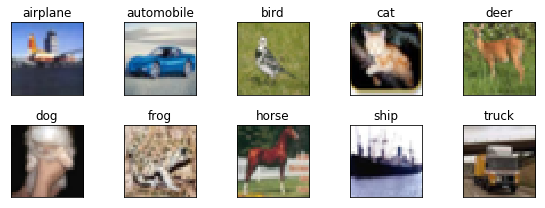

In [4]:
num_classes = len(np.unique(y_train))
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = X_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    img = features_idx[img_num,::]
    ax.set_title(class_names[i])
    plt.imshow(img)
    
plt.tight_layout()

#### Reshaping and normalizing the inputs

In [5]:
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [6]:
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 3, 32, 32)
    X_test = X_test.reshape(X_test.shape[0], 3, 32, 32)
    input_shape = (3, 32, 32)
else:
    X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
    X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)
    input_shape = (32, 32, 3)
    
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.

X_train = np.float32(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

X_test = np.float32(X_test)
X_test = (X_test / 255 - 0.5) * 2
X_test = np.clip(X_test, -1, 1)

print('X_train reshape:', X_train.shape)
print('X_test reshape:', X_test.shape)

X_train reshape: (50000, 32, 32, 3)
X_test reshape: (10000, 32, 32, 3)


In [7]:
print(X_train[0].shape)

(32, 32, 3)


### 2. Define model

#### Generator

In [8]:
# latent space dimension
z = Input(shape=(100,))

# classes
labels = Input(shape=(10,))

# Generator network
merged_layer = Concatenate()([z, labels])

# FC: 2x2x512
generator = Dense(2*2*512, activation='relu')(merged_layer)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)
generator = Reshape((2, 2, 512))(generator)

# # Conv 1: 4x4x256
generator = Conv2DTranspose(256, kernel_size=5, strides=2, padding='same')(generator)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)

# Conv 2: 8x8x128
generator = Conv2DTranspose(128, kernel_size=5, strides=2, padding='same')(generator)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)

# Conv 3: 16x16x64
generator = Conv2DTranspose(64, kernel_size=5, strides=2, padding='same')(generator)
generator = BatchNormalization(momentum=0.9)(generator)
generator = LeakyReLU(alpha=0.1)(generator)

# Conv 4: 32x32x3
generator = Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh')(generator)

# generator = Model(inputs=[z, labels], outputs=out_g)
generator = Model(inputs=[z, labels], outputs=generator, name='generator')

#### Generator model visualization

In [9]:
# prints a summary representation of your model
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 110)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2048)         227328      concatenate_1[0][0]              
__________

#### Discriminator

In [10]:
# input image
img_input = Input(shape=(X_train[0].shape))

# Conv 1: 16x16x64
discriminator = Conv2D(64, kernel_size=5, strides=2, padding='same')(img_input)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

# Conv 2:
discriminator = Conv2D(128, kernel_size=5, strides=2, padding='same')(discriminator)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

# Conv 3: 
discriminator = Conv2D(256, kernel_size=5, strides=2, padding='same')(discriminator)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

# Conv 4: 
discriminator = Conv2D(512, kernel_size=5, strides=2, padding='same')(discriminator)
discriminator = BatchNormalization(momentum=0.9)(discriminator)
discriminator = LeakyReLU(alpha=0.1)(discriminator)

# FC
discriminator = Flatten()(discriminator)

# Concatenate 
merged_layer = Concatenate()([discriminator, labels])
discriminator = Dense(512, activation='relu')(merged_layer)
    
# Output
discriminator = Dense(1, activation='sigmoid')(discriminator)

discriminator = Model(inputs=[img_input, labels], outputs=discriminator, name='discriminator')

#### Discriminator model visualization

In [11]:
# prints a summary representation of your model
discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   4864        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 16, 16, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, 16, 16, 64)   0           batch_normalization_5[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

### 3. Compile model

#### Compile discriminator

In [12]:
# # Optimizer
discriminator.compile(Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy',
                      metrics=['binary_accuracy'])

#### Combined network

In [13]:
discriminator.trainable = False

label = Input(shape=(10,), name='label')
z = Input(shape=(100,), name='z')

fake_img = generator([z, label])
validity = discriminator([fake_img, label])

d_g = Model([z, label], validity, name='adversarial')

d_g.compile(Adam(lr=0.0004, beta_1=0.5), loss='binary_crossentropy',
            metrics=['binary_accuracy'])

In [14]:
# prints a summary representation of your model
d_g.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z (InputLayer)                  (None, 100)          0                                            
__________________________________________________________________________________________________
label (InputLayer)              (None, 10)           0                                            
__________________________________________________________________________________________________
generator (Model)               (None, 32, 32, 3)    4543363     z[0][0]                          
                                                                 label[0][0]                      
__________________________________________________________________________________________________
discriminator (Model)           (None, 1)            5365121     generator[1][0]                  
          

### 4. Fit model


epoch = 1/100, d_loss=0.291, g_loss=4.552                                                                                                                        


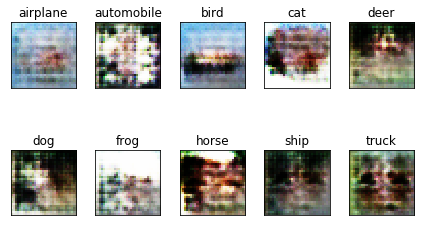

epoch = 2/100, d_loss=0.293, g_loss=1.074                                                                                                                        
epoch = 3/100, d_loss=0.658, g_loss=3.456                                                                                                                        
epoch = 4/100, d_loss=0.977, g_loss=2.526                                                                                                                         
epoch = 5/100, d_loss=0.327, g_loss=3.064                                                                                                                         
epoch = 6/100, d_loss=0.417, g_loss=2.567                                                                                                                         
epoch = 7/100, d_loss=0.235, g_loss=5.728                                                                                                                         
epoch = 8/100, d_loss=0.

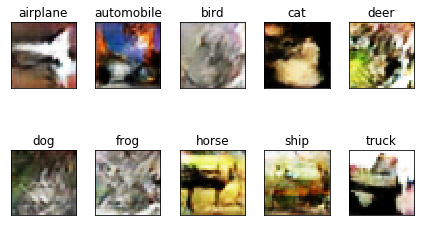

epoch = 12/100, d_loss=0.464, g_loss=4.647                                                                                                                         
epoch = 13/100, d_loss=0.428, g_loss=3.149                                                                                                                         
epoch = 14/100, d_loss=1.860, g_loss=1.357                                                                                                                         
epoch = 15/100, d_loss=0.236, g_loss=14.140                                                                                                                        
epoch = 16/100, d_loss=0.181, g_loss=2.727                                                                                                                         
epoch = 17/100, d_loss=0.176, g_loss=0.829                                                                                                                         
epoch = 18/100, 

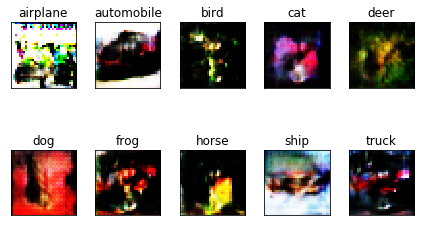

epoch = 22/100, d_loss=0.165, g_loss=0.226                                                                                                                         
epoch = 23/100, d_loss=0.163, g_loss=16.118                                                                                                                        
epoch = 24/100, d_loss=0.178, g_loss=4.787                                                                                                                         
epoch = 25/100, d_loss=0.164, g_loss=15.382                                                                                                                        
epoch = 26/100, d_loss=0.163, g_loss=16.117                                                                                                                        
epoch = 27/100, d_loss=0.267, g_loss=3.686                                                                                                                         
epoch = 28/100, 

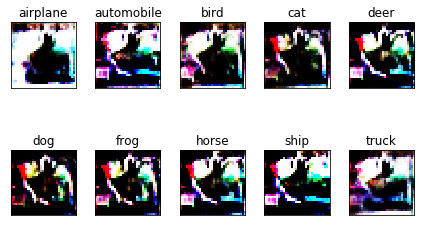

epoch = 32/100, d_loss=0.163, g_loss=16.118                                                                                                                        
epoch = 33/100, d_loss=0.175, g_loss=4.533                                                                                                                         
epoch = 34/100, d_loss=0.163, g_loss=16.118                                                                                                                        
epoch = 35/100, d_loss=0.164, g_loss=1.335                                                                                                                         
epoch = 36/100, d_loss=0.165, g_loss=4.022                                                                                                                         
epoch = 37/100, d_loss=0.163, g_loss=6.743                                                                                                                         
epoch = 38/100, 

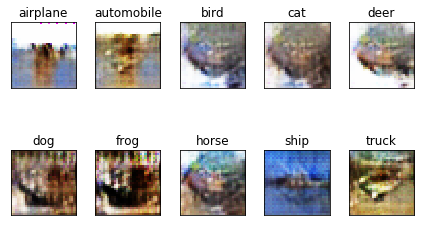

epoch = 42/100, d_loss=0.163, g_loss=16.118                                                                                                                        
epoch = 43/100, d_loss=0.163, g_loss=16.118                                                                                                                        
epoch = 44/100, d_loss=0.169, g_loss=13.677                                                                                                                        
epoch = 45/100, d_loss=0.163, g_loss=16.118                                                                                                                        
epoch = 46/100, d_loss=0.163, g_loss=16.118                                                                                                                        
epoch = 47/100, d_loss=0.164, g_loss=16.118                                                                                                                        
epoch = 48/100, 

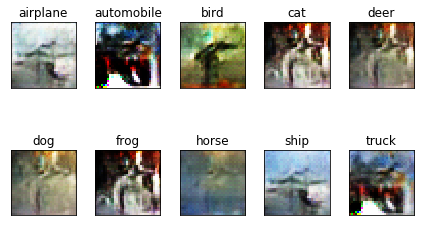

epoch = 52/100, d_loss=0.173, g_loss=10.406                                                                                                                        
epoch = 53/100, d_loss=0.178, g_loss=7.863                                                                                                                         
epoch = 54/100, d_loss=0.170, g_loss=9.903                                                                                                                         
epoch = 55/100, d_loss=0.178, g_loss=10.376                                                                                                                        
epoch = 56/100, d_loss=0.317, g_loss=3.545                                                                                                                         
epoch = 57/100, d_loss=0.166, g_loss=11.222                                                                                                                        
epoch = 58/100, 

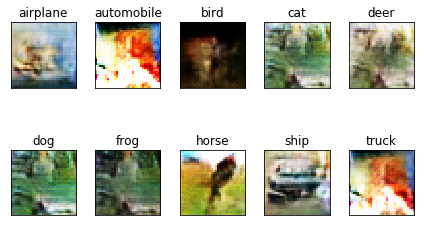

epoch = 62/100, d_loss=0.171, g_loss=13.160                                                                                                                        
epoch = 63/100, d_loss=0.166, g_loss=11.635                                                                                                                        
epoch = 64/100, d_loss=0.169, g_loss=9.988                                                                                                                         
epoch = 65/100, d_loss=0.169, g_loss=5.694                                                                                                                         
epoch = 66/100, d_loss=0.172, g_loss=4.253                                                                                                                         
epoch = 67/100, d_loss=0.180, g_loss=7.056                                                                                                                         
epoch = 68/100, 

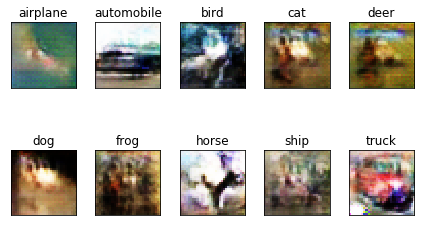

epoch = 72/100, d_loss=0.227, g_loss=5.663                                                                                                                         
epoch = 73/100, d_loss=0.197, g_loss=7.890                                                                                                                         
epoch = 74/100, d_loss=0.167, g_loss=8.998                                                                                                                         
epoch = 75/100, d_loss=0.204, g_loss=6.282                                                                                                                         
epoch = 76/100, d_loss=0.290, g_loss=5.317                                                                                                                         
epoch = 77/100, d_loss=0.181, g_loss=9.622                                                                                                                         
epoch = 78/100, 

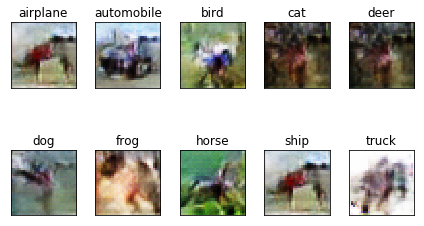

epoch = 82/100, d_loss=0.197, g_loss=9.442                                                                                                                         
epoch = 83/100, d_loss=0.173, g_loss=5.411                                                                                                                         
epoch = 84/100, d_loss=0.168, g_loss=8.605                                                                                                                         
epoch = 85/100, d_loss=0.165, g_loss=6.293                                                                                                                         
epoch = 86/100, d_loss=0.173, g_loss=8.321                                                                                                                         
epoch = 87/100, d_loss=0.179, g_loss=8.046                                                                                                                         
epoch = 88/100, 

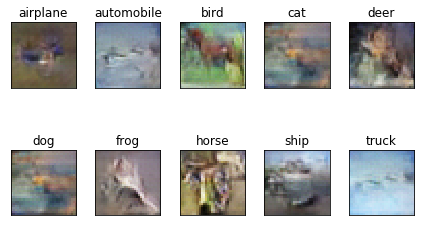

epoch = 92/100, d_loss=0.172, g_loss=7.939                                                                                                                         
epoch = 93/100, d_loss=0.172, g_loss=12.621                                                                                                                        
epoch = 94/100, d_loss=0.193, g_loss=11.150                                                                                                                        
epoch = 95/100, d_loss=0.178, g_loss=6.047                                                                                                                         
epoch = 96/100, d_loss=0.209, g_loss=5.722                                                                                                                         
epoch = 97/100, d_loss=0.180, g_loss=12.926                                                                                                                        
epoch = 98/100, 

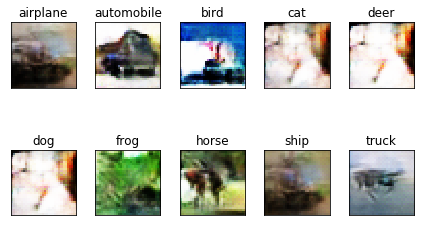

In [15]:
epochs = 100
batch_size = 32
smooth = 0.1
latent_dim = 100

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
d_g_loss = []

for e in range(epochs + 1):
    for i in range(len(X_train) // batch_size):
        
        # Train Discriminator weights
        discriminator.trainable = True
        
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        real_labels = to_categorical(y_train[i*batch_size:(i+1)*batch_size].reshape(-1, 1), num_classes=10)
        
        d_loss_real = discriminator.train_on_batch(x=[X_batch, real_labels],
                                                   y=real * (1 - smooth))
        
        # Fake Samples
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = to_categorical(np.random.randint(0, 10, batch_size).reshape(-1, 1), num_classes=10)
        X_fake = generator.predict_on_batch([z, random_labels])
        
        d_loss_fake = discriminator.train_on_batch(x=[X_fake, random_labels], y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
        # Train Generator weights
        discriminator.trainable = False
        
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        random_labels = to_categorical(np.random.randint(0, 10, batch_size).reshape(-1, 1), num_classes=10)
        d_g_loss_batch = d_g.train_on_batch(x=[z, random_labels], y=real)
   
        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    d_g_loss.append(d_g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        z = np.random.normal(loc=0, scale=1, size=(samples, latent_dim))
        labels = to_categorical(np.arange(0, 10).reshape(-1, 1), num_classes=10)
        
        x_fake = generator.predict([z, labels])
        x_fake = np.clip(x_fake, -1, 1)
        x_fake = (x_fake + 1) * 127
        x_fake = np.round(x_fake).astype('uint8')

        for k in range(samples):
            plt.subplot(2, 5, k + 1, xticks=[], yticks=[])
            plt.imshow(x_fake[k])
            plt.title(class_names[k])

        plt.tight_layout()
        plt.show()

### 5. Evaluate model

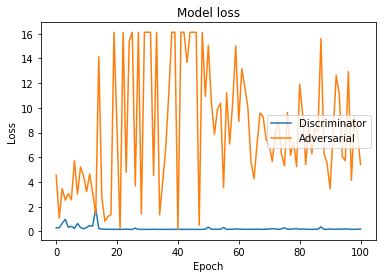

In [16]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(d_g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Adversarial'], loc='center right')
plt.show()

## References

* [Conditional Generative Adversarial Nets](https://arxiv.org/pdf/1411.1784.pdf)
* [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)
* [The CIFAR-10 dataset](https://www.cs.toronto.edu/%7Ekriz/cifar.html)
* [Keras-GAN](https://github.com/eriklindernoren/Keras-GAN)